# Word Embedding Analysis

Analysis of the knowledge base phrase embeddings generated for RCV1.

## Load imports

In [24]:
# Make common scripts visible
import sys
sys.path.append('../common/')
sys.path.append('../kb-classifier/')

# To compare similarity of embeddings
from collections import defaultdict
import numpy as np
import heapq
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from adjustText import adjust_text

# The import that enables a KB phrase embedding to be obtained for a word
from embeddings import EmbeddingModel
from loader import load_preprocessed_data
from lookup_tables import int_to_topic_code, topic_code_to_topic_dict

## Quick test

Ensure the phrase embeddings for a few words can be obtained and their cosine similarity scores calculated.

In [2]:
embedding_model = EmbeddingModel(embedding_file_path='../rcv1/embeddings/phrase_embeddings.avro',
                                 topic_id_mapping_path='../rcv1/embeddings/phrase_topic_id_mapping.csv')

In [3]:
def print_similarity(embedding_1, embedding_2, word_1, word_2):
    similarity = cosine_similarity(embedding_1[np.newaxis, :], embedding_2[np.newaxis, :])
    print('Cosine similarity between {} and {} is {:.4f}'.format(word_1, word_2, similarity[0,0]))

# Economics
    
rupiah_embedding = embedding_model.get_vector('rupiah')
dollar_embedding = embedding_model.get_vector('dollar')
currency_embedding = embedding_model.get_vector('currency')

print_similarity(rupiah_embedding, dollar_embedding, 'rupiah', 'dollar')
print_similarity(rupiah_embedding, currency_embedding, 'rupiah', 'currency')
print_similarity(dollar_embedding, currency_embedding, 'dollar', 'currency')
print('---------------------------------------------------------')

# Sports

football_embedding = embedding_model.get_vector('football')
cricket_embedding = embedding_model.get_vector('cricket')
sport_embedding = embedding_model.get_vector('sport')

print_similarity(football_embedding, cricket_embedding, 'football', 'cricket')
print_similarity(football_embedding, sport_embedding, 'football', 'sport')
print_similarity(cricket_embedding, sport_embedding, 'cricket', 'sport')
print('---------------------------------------------------------')

# Between the two categories

print_similarity(currency_embedding, sport_embedding, 'currency', 'sport')
print_similarity(rupiah_embedding, football_embedding, 'rupiah', 'football')
print_similarity(dollar_embedding, football_embedding, 'dollar', 'football')
print_similarity(rupiah_embedding, cricket_embedding, 'rupiah', 'cricket')
print_similarity(dollar_embedding, cricket_embedding, 'dollar', 'cricket')

Cosine similarity between rupiah and dollar is 0.6903
Cosine similarity between rupiah and currency is 0.5634
Cosine similarity between dollar and currency is 0.8338
---------------------------------------------------------
Cosine similarity between football and cricket is 0.8616
Cosine similarity between football and sport is 0.7368
Cosine similarity between cricket and sport is 0.8858
---------------------------------------------------------
Cosine similarity between currency and sport is 0.0075
Cosine similarity between rupiah and football is 0.0014
Cosine similarity between dollar and football is 0.0019
Cosine similarity between rupiah and cricket is 0.0027
Cosine similarity between dollar and cricket is 0.0026


## Get top terms from each RCV1 topic

We may potentially want to use these for the t-SNE visualisation.

In [15]:
x, y = load_preprocessed_data('../rcv1/data/rcv1_kb.csv')

# To store the total number of occurences of each token for a particular topic
word_counts = {}

# RCV1 has 6 topics
for i in range(6):
    word_counts[i] = defaultdict(int)

# For each topic maintain a count of all words encountered
for i in range(len(x)):
    
    article = x[i]
    topic = y[i]
    
    tokens = article.split()
    for token in tokens:
        word_counts[topic][token] += 1

# Keep top words per topic
capacity = 50
top_words_per_topic = {}

for topic in word_counts.keys():
    top_words = []
    heap_size = 0

    for word, count in word_counts[topic].items():
        if heap_size < capacity:
            heapq.heappush(top_words, (count, word))
            heap_size += 1
        else:
            heapq.heappushpop(top_words, (count, word))
            
    top_words_per_topic[topic] = [heapq.heappop(top_words) for i in range(len(top_words))]

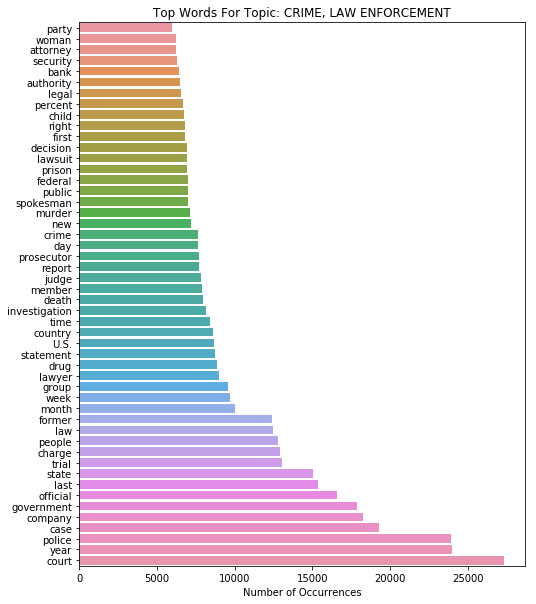

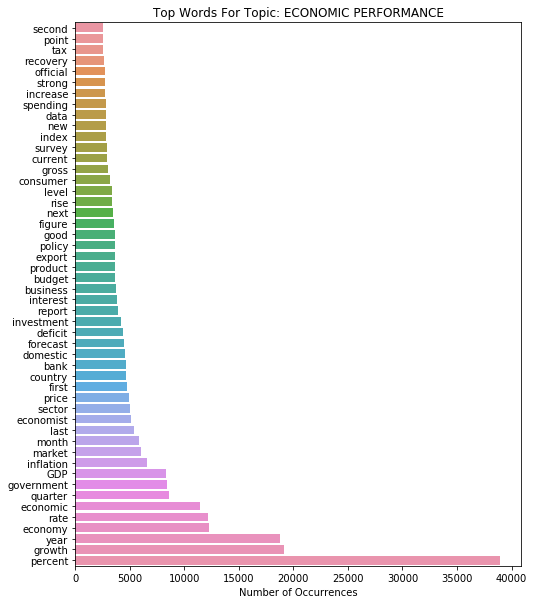

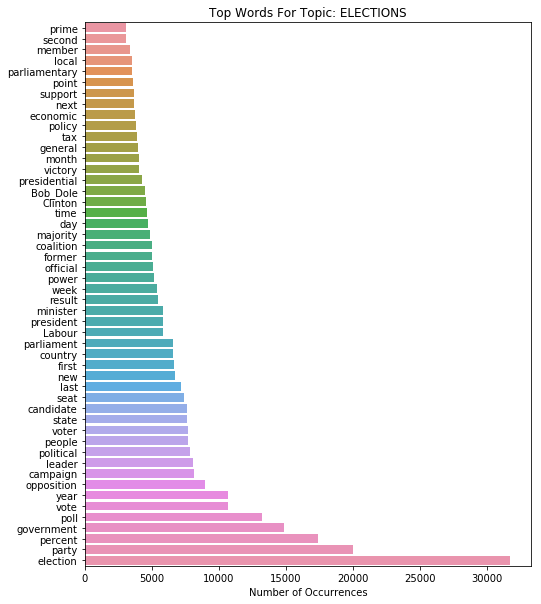

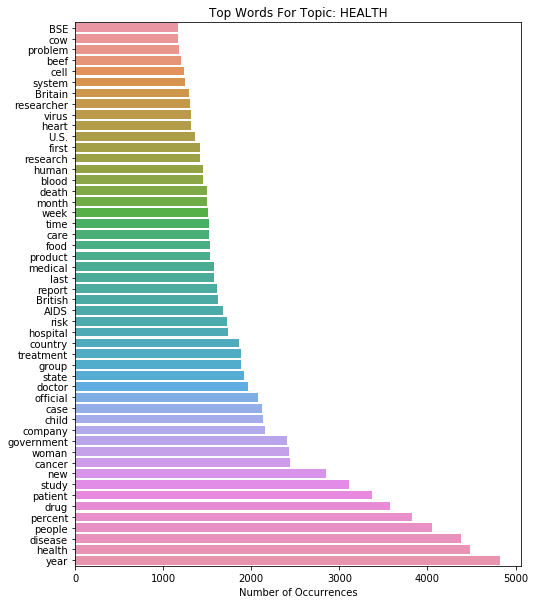

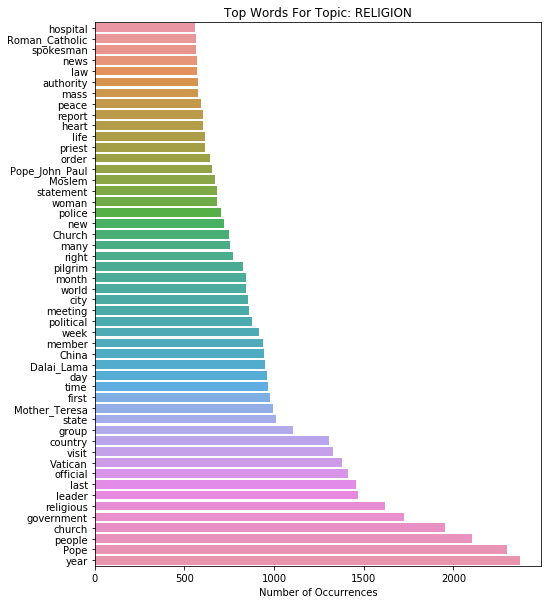

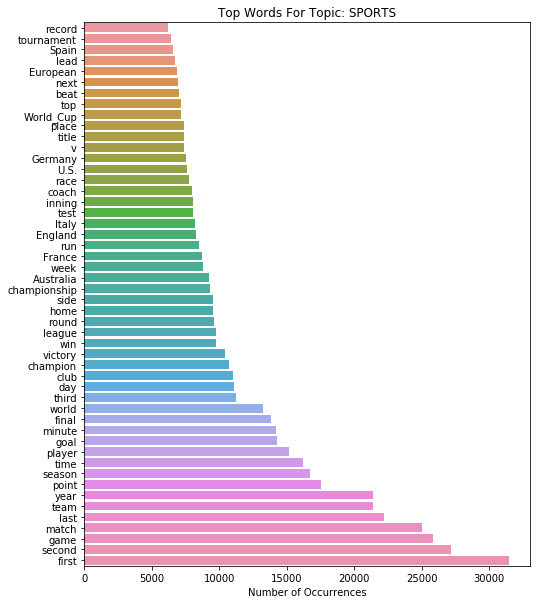

In [16]:
# Plot the top words per topic
for topic, top_words in top_words_per_topic.items():
    x = []
    y = []
    
    readable_topic = topic_code_to_topic_dict[int_to_topic_code[topic]]
    
    for count, word in top_words:
        y.append(word)
        x.append(count)

    plt.figure(figsize=(8, 10))
    plt.title('Top Words For Topic: {}'.format(readable_topic))
    plt.xlabel('Number of Occurrences')
    sns.barplot(x=x, y=y)
    plt.show()

## Cosine similarity of symonyms and related terms

In [6]:
# Try out some symonyms and related terms

# Crime and Law Enforcement
lawyer_embedding = embedding_model.get_vector('lawyer')
attorney_embedding = embedding_model.get_vector('attorney')
print_similarity(lawyer_embedding, attorney_embedding, 'lawyer', 'attorney')

# Economic Performance
deficit_embedding = embedding_model.get_vector('economist')
shortfall_embedding = embedding_model.get_vector('economy')
print_similarity(deficit_embedding, shortfall_embedding, 'economist', 'economy')

# Elections
bill_clinton_embedding = embedding_model.get_vector('Bill Clinton')
george_bush_embedding = embedding_model.get_vector('George Bush')
print_similarity(bill_clinton_embedding, george_bush_embedding, 'Bill Clinton', 'George Bush')

# Health
cancer_embedding = embedding_model.get_vector('cancer')
disease_embedding = embedding_model.get_vector('disease')
print_similarity(cancer_embedding, disease_embedding, 'cancer', 'disease')

# Religion
dalai_lama_embedding = embedding_model.get_vector('Dalai Lama')
mother_teresa_embedding = embedding_model.get_vector('Mother Teresa')
print_similarity(dalai_lama_embedding, mother_teresa_embedding, 'Dalai Lama', 'Mother Teresa')

# Sports
game_embedding = embedding_model.get_vector('game')
match_embedding = embedding_model.get_vector('match')
print_similarity(game_embedding, match_embedding, 'game', 'match')

Cosine similarity between lawyer and attorney is 0.9357
Cosine similarity between economist and economy is 0.4753
Cosine similarity between Bill Clinton and George Bush is 0.4996
Cosine similarity between cancer and disease is 0.8776
Cosine similarity between Dalai Lama and Mother Teresa is 0.6897
Cosine similarity between game and match is 0.8964


In [7]:
# Plot a table representation of the above cosine similarities
phrases = ['lawyer       ',
           'attorney     ',
           'economist    ',
           'economy      ',
           'Bill Clinton ',
           'George Bush  ',
           'cancer       ',
           'disease      ',
           'Dalai Lama   ',
           'Mother Teresa',
           'game         ',
           'match        ']

embeddings = [embedding_model.get_vector(phrase.strip()) for phrase in phrases]

for i in range(len(phrases)):
    
    to_print = phrases[i] + '\t'
    
    for j in range(len(phrases)):
        
        to_print += '{:.4f}\t'.format(cosine_similarity(embeddings[i][np.newaxis, :], 
                                                        embeddings[j][np.newaxis, :])[0,0])
    
    print(to_print)

lawyer       	1.0000	0.9357	0.0453	0.0891	0.2493	0.1428	0.0264	0.0268	0.0815	0.0209	0.0521	0.0247	
attorney     	0.9357	1.0000	0.0346	0.0805	0.2914	0.1185	0.0279	0.0291	0.0799	0.0165	0.0559	0.0323	
economist    	0.0453	0.0346	1.0000	0.4753	0.1098	0.0228	0.0112	0.0197	0.0252	0.0123	0.0846	0.0331	
economy      	0.0891	0.0805	0.4753	1.0000	0.2299	0.1478	0.0263	0.0476	0.0908	0.0436	0.0976	0.0477	
Bill Clinton 	0.2493	0.2914	0.1098	0.2299	1.0000	0.4996	0.0486	0.0294	0.2837	0.0643	0.0643	0.0568	
George Bush  	0.1428	0.1185	0.0228	0.1478	0.4996	1.0000	0.1236	0.1329	0.4480	0.2684	0.1620	0.0888	
cancer       	0.0264	0.0279	0.0112	0.0263	0.0486	0.1236	1.0000	0.8776	0.0133	0.0186	0.0856	0.0334	
disease      	0.0268	0.0291	0.0197	0.0476	0.0294	0.1329	0.8776	1.0000	0.0016	0.0161	0.1001	0.0358	
Dalai Lama   	0.0815	0.0799	0.0252	0.0908	0.2837	0.4480	0.0133	0.0016	1.0000	0.6897	0.0695	0.0221	
Mother Teresa	0.0209	0.0165	0.0123	0.0436	0.0643	0.2684	0.0186	0.0161	0.6897	1.0000	0.0581	0.0075	
game      

In [11]:
# Some analysis of why certain concepts had high cosine similarity even when the relationship was
# not obvious

def get_non_zero_topics(embedding):
    """
    Gets the non zero topics for the embedding
    
    :param embedding: the embedding to obtain non-zero topics for.
    :returns: the set of the non-zero topics present.
    """    
    topics = set([embedding_model.get_topic_for_index(index)
                  for index in range(len(embedding))
                  if embedding[index] > 0])
    
    return topics

def find_intersecting_non_zero_topics(embedding_1, embedding_2):
    """
    Find the intersecting topics between the two embeddings.
    
    :param embedding_1: the first embedding.
    :param embedding_2: the second embedding.
    :returns: the set of the topics the two embeddings have in common.
    """
    topics_1 = get_non_zero_topics(embedding_1)
    topics_2 = get_non_zero_topics(embedding_2)
    
    return topics_1.intersection(topics_2)


topics_in_common = find_intersecting_non_zero_topics(bill_clinton_embedding, attorney_embedding)
print('Topics in common for Bill Clinton and Attorney: {}'.format(topics_in_common))
print('')

for topic in topics_in_common:
    embed_pos = embedding_model.get_index_for_topic(topic)
    print('{} score for Bill Clinton: {:.4f}, Attorney: {:.4f}'.format(topic,
                                                                       bill_clinton_embedding[embed_pos],
                                                                       attorney_embedding[embed_pos]))
print('')

topics_in_common = find_intersecting_non_zero_topics(bill_clinton_embedding, dalai_lama_embedding)
print('Topics in common for Bill Clinton and Dalai Lama: {}'.format(topics_in_common))
print('')

for topic in topics_in_common:
    embed_pos = embedding_model.get_index_for_topic(topic)
    print('{} score for Bill Clinton: {:.4f}, Dalai Lama: {:.4f}'.format(topic,
                                                                       bill_clinton_embedding[embed_pos],
                                                                       dalai_lama_embedding[embed_pos]))
print('')

Topics in common for Bill Clinton and Attorney: {'Crime', 'Services_(economics)', 'Health', 'Political_philosophy', 'Politics_by_location', 'Legal_history', 'Political_parties', 'Economics', 'Criminal_justice', 'Politics_by_issue', 'Political_science', 'Business', 'Law_by_region', 'Politics', 'Quality_of_life', 'Business_economics', 'Political_history', 'Law_by_issue', 'Government', 'Industries', 'Law'}

Crime score for Bill Clinton: 0.0522, Attorney: 0.0281
Services_(economics) score for Bill Clinton: 0.0005, Attorney: 0.0092
Health score for Bill Clinton: 0.0106, Attorney: 0.0016
Political_philosophy score for Bill Clinton: 0.0210, Attorney: 0.0151
Politics_by_location score for Bill Clinton: 0.0478, Attorney: 0.0296
Legal_history score for Bill Clinton: 0.0143, Attorney: 0.0135
Political_parties score for Bill Clinton: 0.1010, Attorney: 0.0043
Economics score for Bill Clinton: 0.0125, Attorney: 0.0002
Criminal_justice score for Bill Clinton: 0.0008, Attorney: 0.0048
Politics_by_issu

## t-SNE plot using selected terms from each RCV1 topic

10 terms taken from top 50 for each RCV1 topic.

In [12]:
dalai_lama_embedding = embedding_model.get_vector('court case')

In [22]:
crime_law_terms = ['court case',
                   'police',
                   'trial',
                   'charge',
                   'lawyer',
                   'statement',
                   'investigation',
                   'death',
                   'judge',
                   'prosecutor']
economic_terms = ['economy',
                  'growth rate',
                  'GDP',
                  'inflation',
                  'market',
                  'bank',
                  'forecast',
                  'deficit',
                  'investment',
                  'interest']
elections_terms = ['election',
                   'government',
                   'poll',
                   'vote',
                   'campaign',
                   'voter',
                   'candidate',
                   'parliament',
                   'president',
                   'coalition']
health_terms = ['health',
                'disease',
                'drug',
                'patient',
                'study',
                'cancer',
                'doctor',
                'treatment',
                'hospital',
                'medical']
religion_terms = ['Pope',
                  'church',
                  'religious leader',
                  'Vatican',
                  'Mother Teresa',
                  'Dalai Lama',
                  'pilgrim',
                  'Moslem',
                  'priest',
                  'mass']
sports_terms = ['game',
                'match',
                'team',
                'season',
                'player',
                'goal',
                'league',
                'World Cup',
                'championship',
                'coach']

all_terms = crime_law_terms + economic_terms + elections_terms + health_terms + religion_terms + sports_terms
all_terms_embedded = [embedding_model.get_vector(term) for term in all_terms]
all_terms_embedded = np.array(all_terms_embedded)

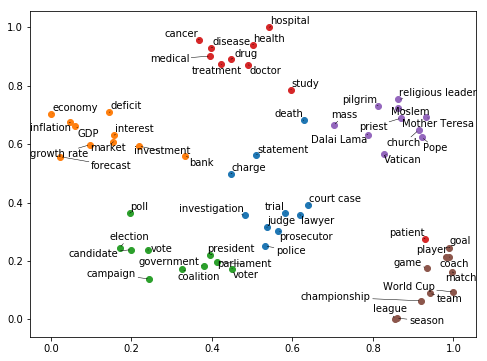

In [148]:
# Perform the t-SNE optimisation
tsne = manifold.TSNE(n_components=2, init='pca', metric='cosine', learning_rate=40.0, random_state=42)
X = tsne.fit_transform(all_terms_embedded)

# Do the t-SNE plot
x_min, x_max = np.min(X, 0), np.max(X, 0)
X_normalised = (X - x_min) / (x_max - x_min)

crime_law_indexes = slice(0, 10, 1)
economic_indexes = slice(10, 20, 1)
elections_indexes = slice(20, 30, 1)
health_indexes = slice(30, 40, 1)
religion_indexes = slice(40, 50, 1)
sports_indexes = slice(50, 60, 1)

texts = []
fig, ax = plt.subplots(figsize=(8,6))

def plot_topic(indexes, terms):
    ax.scatter(X_normalised[indexes, 0], X_normalised[indexes, 1])    
    for i, term in enumerate(terms):    
        texts.append(ax.text(X_normalised[indexes.start+i, 0], X_normalised[indexes.start+i, 1], term))

plot_topic(crime_law_indexes, crime_law_terms)
plot_topic(economic_indexes, economic_terms)
plot_topic(elections_indexes, elections_terms)
plot_topic(health_indexes, health_terms)
plot_topic(religion_indexes, religion_terms)
plot_topic(sports_indexes, sports_terms)

# Move the phrase labels arounds so they don't collide
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.show()